# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
-  Использовать CrossEntropyLoss и L2-регуляризацию.
-  Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
-  * (**+2 балла**) Добавить Batch normalization.
-  * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
-  * (**+1 балл**) Также реализовать оптимизатор Adam.

In [2]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Датасет

MNIST состоит из изображений рукописных цифр от 0 до 9. Всего в датасете 70 000 изображений, из которых 60 000 предназначены для обучения, а 10 000 – для тестирования.

Каждое изображение имеет размер 28×28 пикселей, представлено в оттенках серого (одноцветные), где значение пикселя обычно нормализовано в диапазоне [0, 1].


Количество обучающих примеров: 48000
Количество примеров валидации: 12000
Количество тестовых примеров: 10000


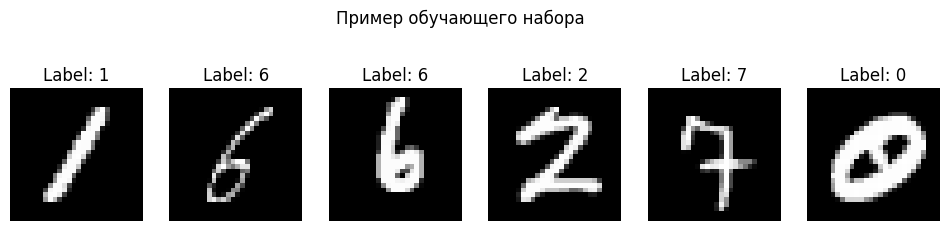

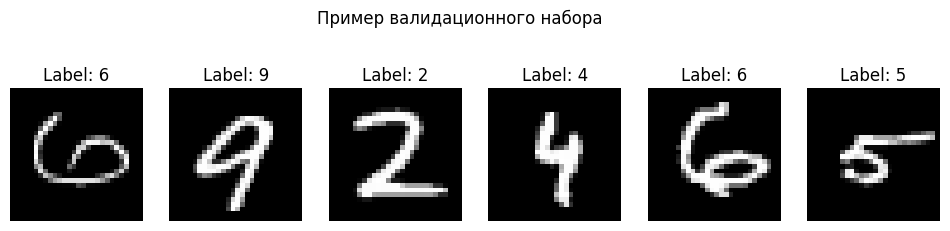

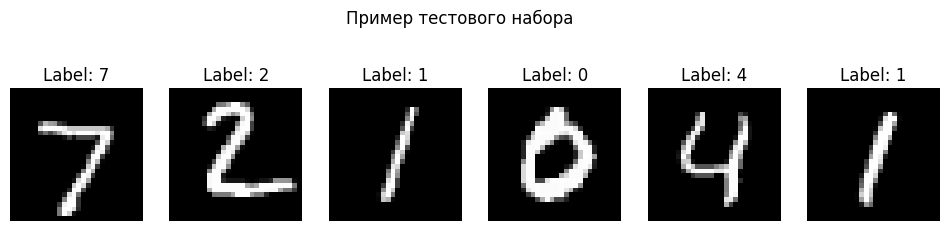

In [3]:

transform = transforms.Compose([transforms.ToTensor()])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(f'Количество обучающих примеров: {len(train_dataset)}')
print(f'Количество примеров валидации: {len(val_dataset)}')
print(f'Количество тестовых примеров: {len(mnist_test)}')


def show_samples(data_loader, title, n_samples=6):
    images, labels = next(iter(data_loader))

    plt.figure(figsize=(12, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


show_samples(train_loader, "Пример обучающего набора")
show_samples(val_loader, "Пример валидационного набора")
show_samples(test_loader, "Пример тестового набора")


### Нейронная сеть

1. Реализация слоёв FullyConnectedLayer и ReluLayer
2. Реализация нейронной сети

In [4]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(FullyConnectedLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


class ReluLayer(nn.Module):
    def __init__(self):
        super(ReluLayer, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x)


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, use_batchnorm=False):
        super(NeuralNetwork, self).__init__()
        self.fc1 = FullyConnectedLayer(input_dim, hidden_dim)
        self.use_batchnorm = use_batchnorm
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = ReluLayer()
        self.fc2 = FullyConnectedLayer(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


### Кастомный оптимизатор Adam

In [5]:
class CustomAdam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(CustomAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam не поддерживает разреженные градиенты")

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                step_size = group['lr'] * (bias_correction2 ** 0.5) / bias_correction1

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

        return loss


### Проверка градиента
Градиент – это метод верификации корректности вычисления градиентов, используемый при разработке нейронных сетей.

In [26]:
def gradient_check(model, loss_fn, inputs, labels, param, epsilon=1e-5, num_checks=10000):
    original_param = param.data.clone()

    model.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    analytical_grad = param.grad.data.clone()

    numerical_grad = torch.zeros_like(param.data)

    num_elements = param.data.numel()
    indices = torch.randint(0, num_elements, (num_checks,))

    param_flat = param.data.view(-1)
    num_grad_flat = numerical_grad.view(-1)
    analytical_grad_flat = analytical_grad.view(-1)

    for i in indices:
        orig = param_flat[i].item()

        param_flat[i] = orig + epsilon
        loss_plus = loss_fn(model(inputs), labels)

        param_flat[i] = orig - epsilon
        loss_minus = loss_fn(model(inputs), labels)

        param_flat[i] = orig

        num_grad_flat[i] = (loss_plus - loss_minus) / (2 * epsilon)

    checked_analytical = analytical_grad_flat[indices]
    checked_numerical = num_grad_flat[indices]
    diff = (checked_analytical - checked_numerical).abs().max().item()

    # print(f"Gradient check for {param_name}: max absolute difference (over {num_checks} random elements) = {diff:.8f}")
    return diff


def train_and_validate(
    model,
    train_loader,
    val_loader,
    test_loader,
    loss_fn,
    optimizer,
    num_epochs=5,
    grad_check_interval=100,
    graph_title="",
    print_test=True
):
    import matplotlib.pyplot as plt

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            if batch_idx % grad_check_interval == 0:
                diff = gradient_check(
                    model, loss_fn, images, labels,
                    model.fc1.linear.weight,
                    epsilon=1e-5,
                    num_checks=10
                )
                # print(f"  [Epoch {epoch+1} | Batch {batch_idx}] Gradient diff = {diff:.6f}")

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация
        model.eval()
        running_val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total

        # print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{graph_title}\nTrain/Val Loss (Last Val Acc = {val_acc:.2f}%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    model.eval()
    running_test_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = 100 * correct / total

    if print_test:
        print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

    return train_losses, val_losses, val_acc, test_acc


In [27]:
def get_optimizer(optimizer_name, params, lr, weight_decay):
    if optimizer_name == "CustomAdam":
        return CustomAdam(params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        return optim.RMSprop(params, lr=lr, alpha=0.99, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")



## Гиперпараметры

**Оптимизатор**:
Мы тестируем два варианта:
- CustomAdam
- RMSprop

Оптимизатор влияет на способ обновления весов и стабильность сходимости.

**Скорость обучения** (learning rate):
Рассматриваются три значения:
- 0.001
- 0.0005
- 0.0001

Learning rate определяет, насколько сильно корректируются веса на каждом шаге. Слишком высокий lr может привести к нестабильности, а слишком низкий – к медленной сходимости.

**L2-регуляризация (weight decay)**:
Подбираем значения:
- 1e-4
- 5e-4
- 1e-3

Weight decay помогает уменьшить переобучение, штрафуя большие веса. Правильный выбор позволяет улучшить способность модели к обобщению.

**Batch Normalization**:
При включенном BN входы слоев нормализуются, что помогает ускорить обучение и сделать его более стабильным. Мы сравниваем результаты с BN включенным и выключенным.

Всего 36 комбинаций.



===== TRAINING: CustomAdam 
lr = 0.001 
weight decays = 0.0001 
Batch Norm = True =====


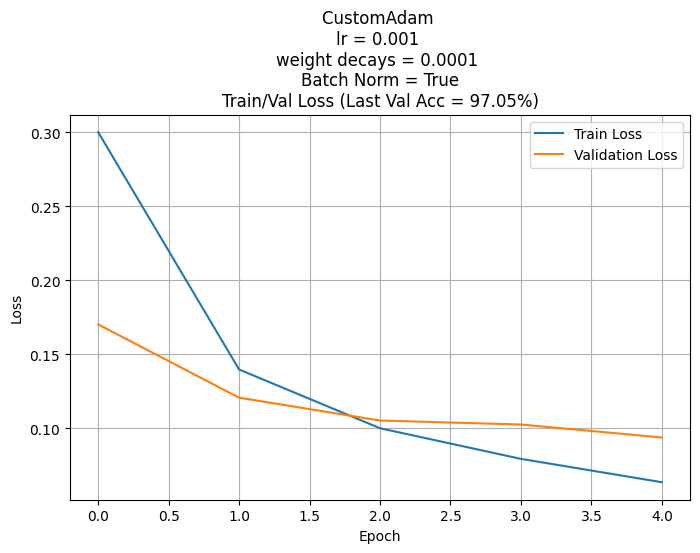


===== TRAINING: CustomAdam 
lr = 0.001 
weight decays = 0.0001 
Batch Norm = False =====


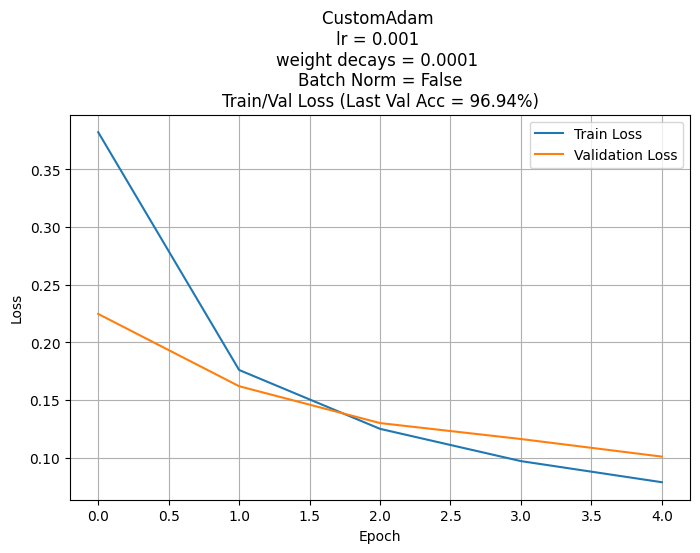


===== TRAINING: CustomAdam 
lr = 0.001 
weight decays = 0.0005 
Batch Norm = True =====


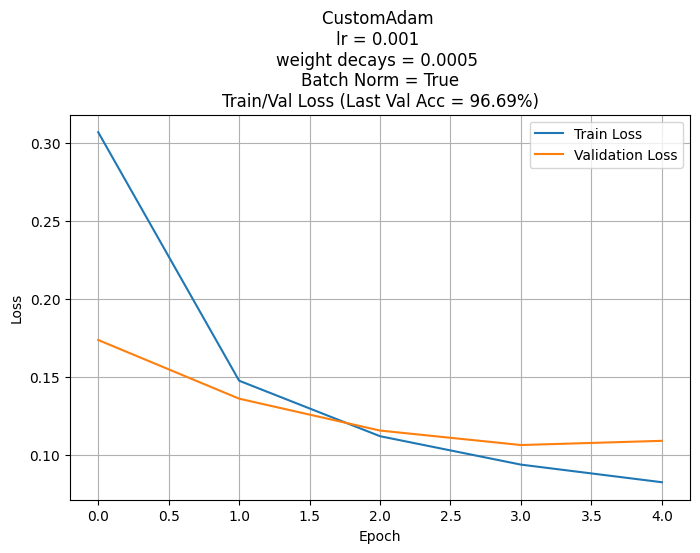


===== TRAINING: CustomAdam 
lr = 0.001 
weight decays = 0.0005 
Batch Norm = False =====


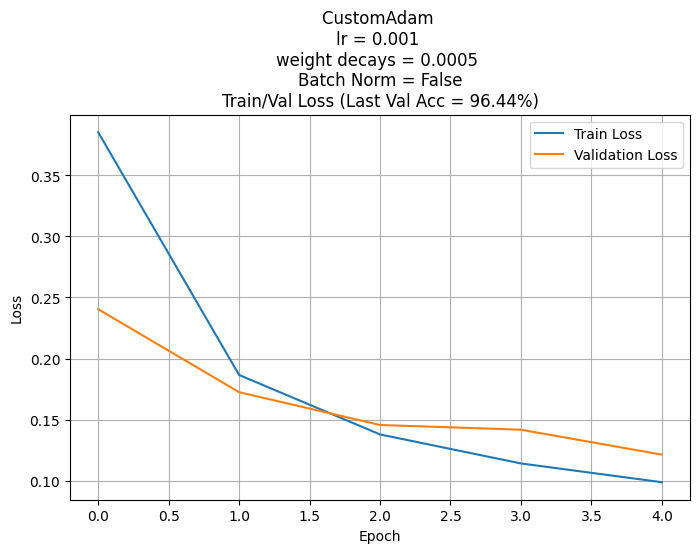


===== TRAINING: CustomAdam 
lr = 0.001 
weight decays = 0.001 
Batch Norm = True =====


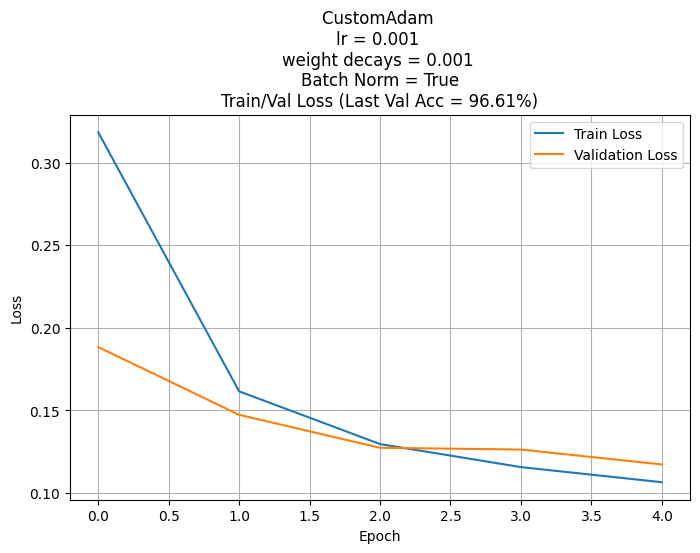


===== TRAINING: CustomAdam 
lr = 0.001 
weight decays = 0.001 
Batch Norm = False =====


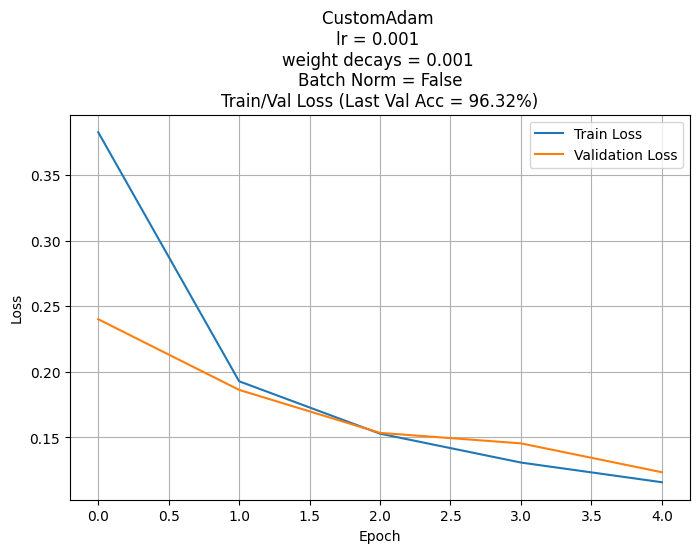


===== TRAINING: CustomAdam 
lr = 0.0005 
weight decays = 0.0001 
Batch Norm = True =====


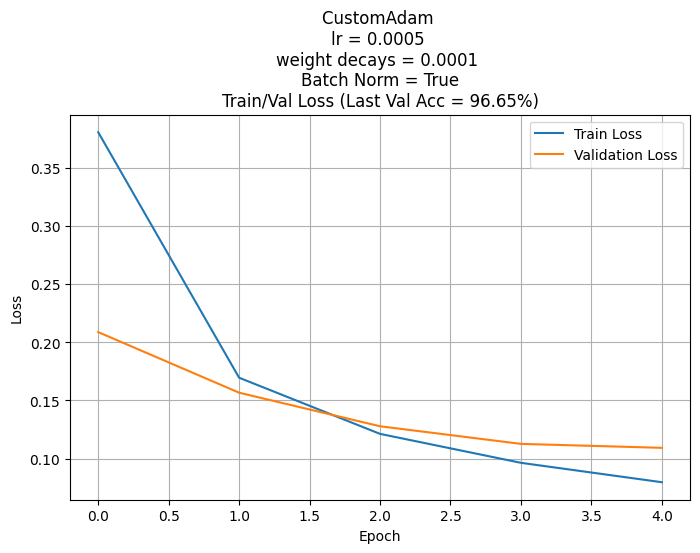


===== TRAINING: CustomAdam 
lr = 0.0005 
weight decays = 0.0001 
Batch Norm = False =====


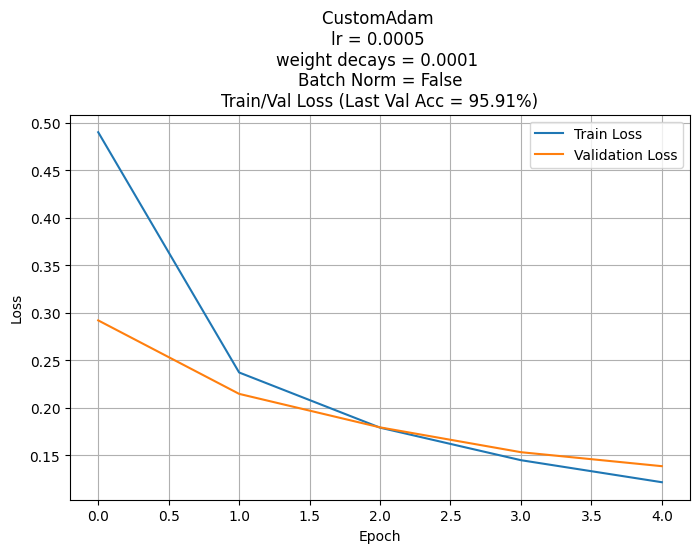


===== TRAINING: CustomAdam 
lr = 0.0005 
weight decays = 0.0005 
Batch Norm = True =====


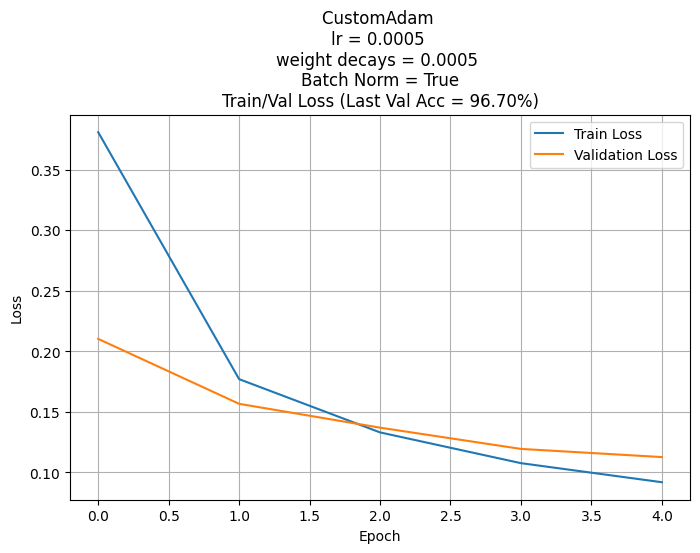


===== TRAINING: CustomAdam 
lr = 0.0005 
weight decays = 0.0005 
Batch Norm = False =====


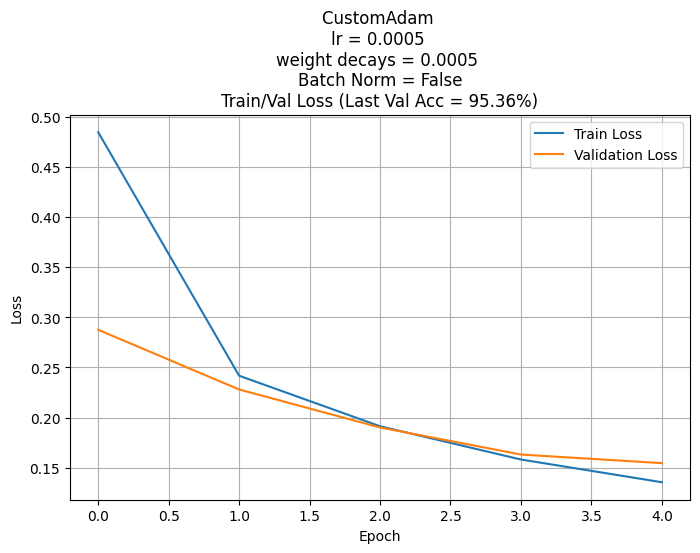


===== TRAINING: CustomAdam 
lr = 0.0005 
weight decays = 0.001 
Batch Norm = True =====


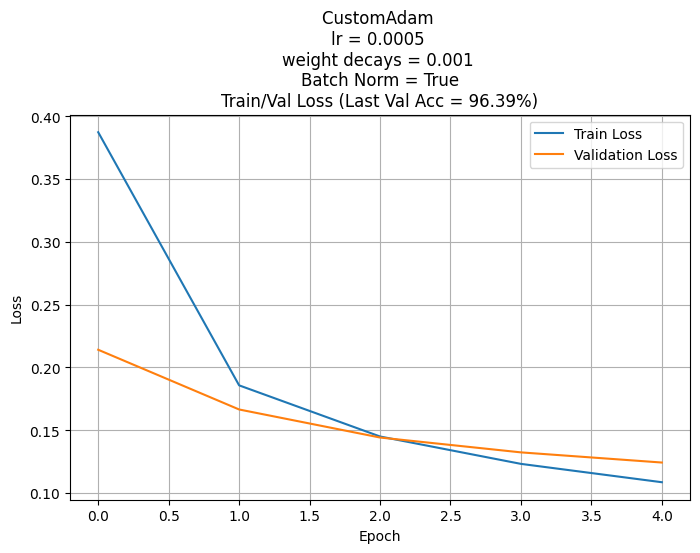


===== TRAINING: CustomAdam 
lr = 0.0005 
weight decays = 0.001 
Batch Norm = False =====


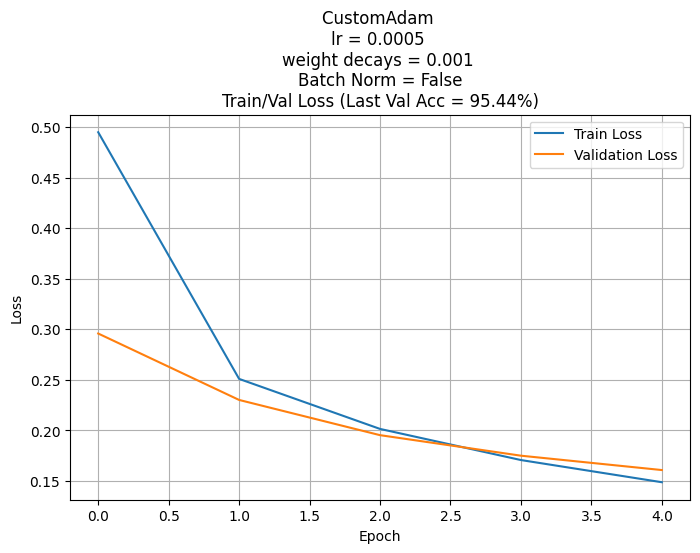


===== TRAINING: CustomAdam 
lr = 0.0001 
weight decays = 0.0001 
Batch Norm = True =====


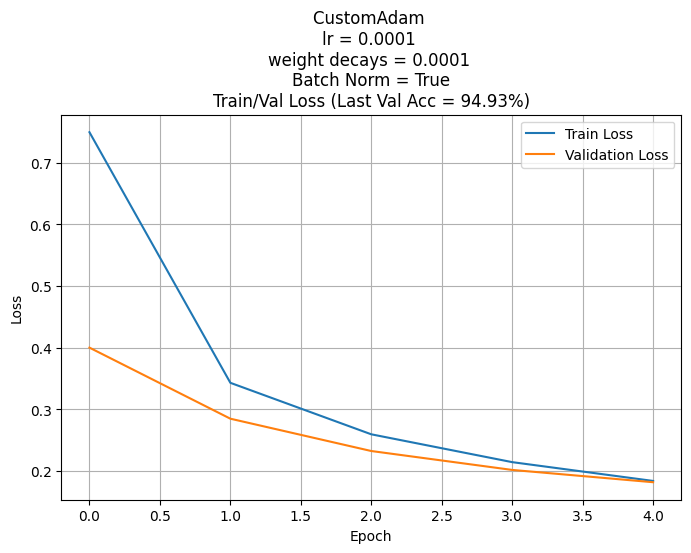


===== TRAINING: CustomAdam 
lr = 0.0001 
weight decays = 0.0001 
Batch Norm = False =====


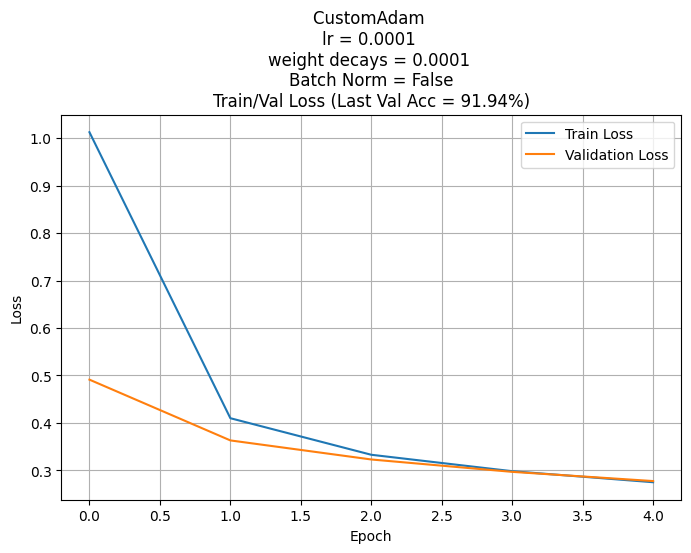


===== TRAINING: CustomAdam 
lr = 0.0001 
weight decays = 0.0005 
Batch Norm = True =====


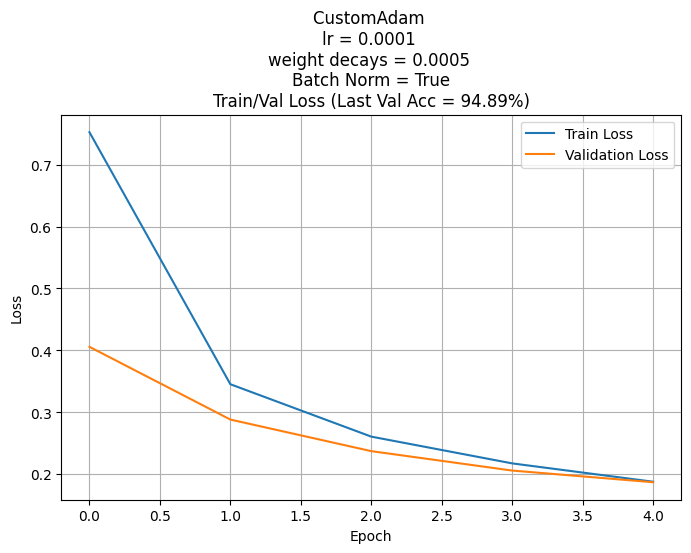


===== TRAINING: CustomAdam 
lr = 0.0001 
weight decays = 0.0005 
Batch Norm = False =====


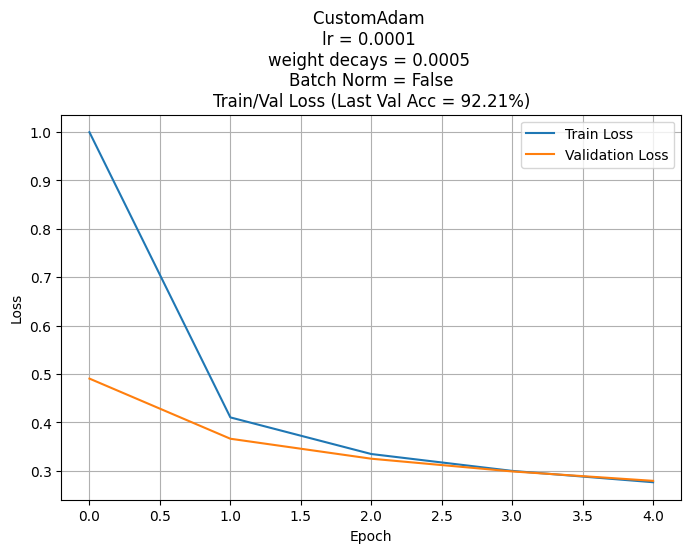


===== TRAINING: CustomAdam 
lr = 0.0001 
weight decays = 0.001 
Batch Norm = True =====


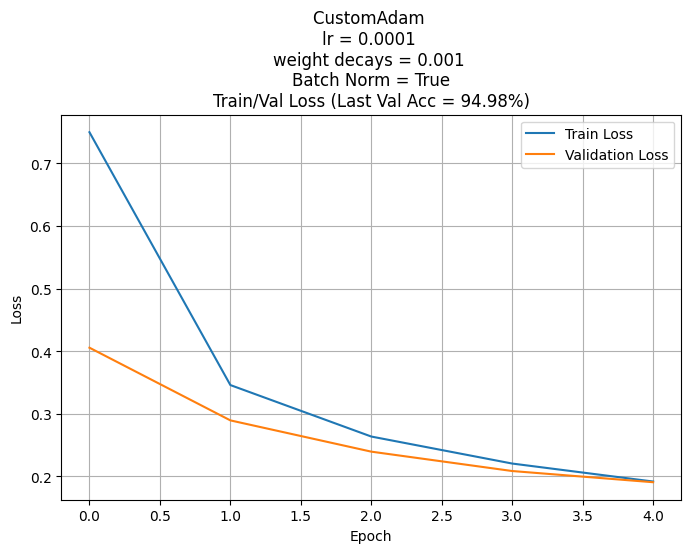


===== TRAINING: CustomAdam 
lr = 0.0001 
weight decays = 0.001 
Batch Norm = False =====


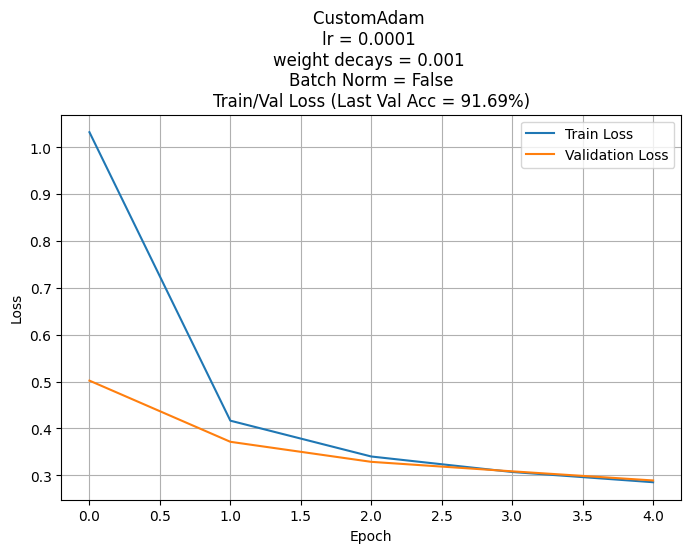


===== TRAINING: RMSprop 
lr = 0.001 
weight decays = 0.0001 
Batch Norm = True =====


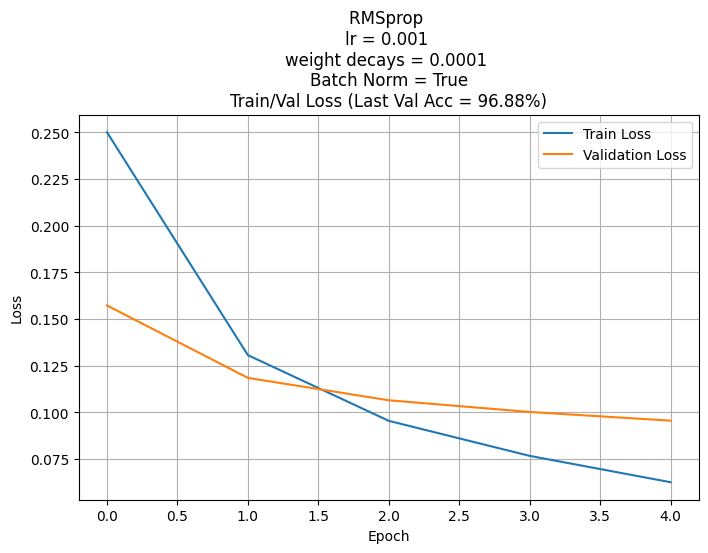


===== TRAINING: RMSprop 
lr = 0.001 
weight decays = 0.0001 
Batch Norm = False =====


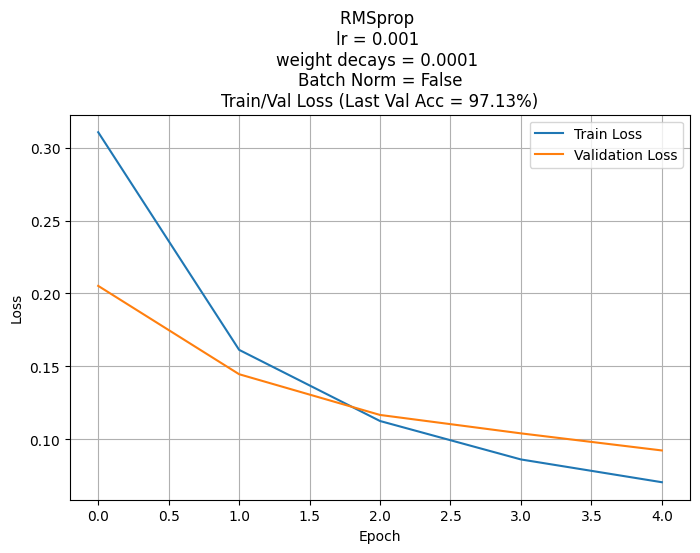


===== TRAINING: RMSprop 
lr = 0.001 
weight decays = 0.0005 
Batch Norm = True =====


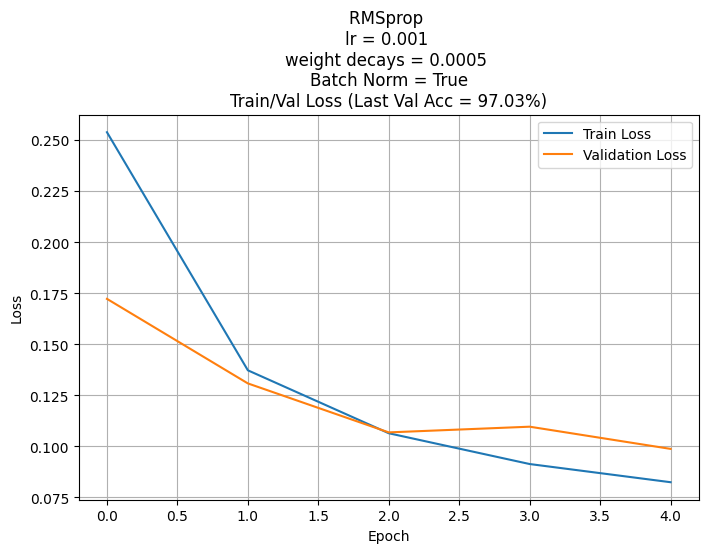


===== TRAINING: RMSprop 
lr = 0.001 
weight decays = 0.0005 
Batch Norm = False =====


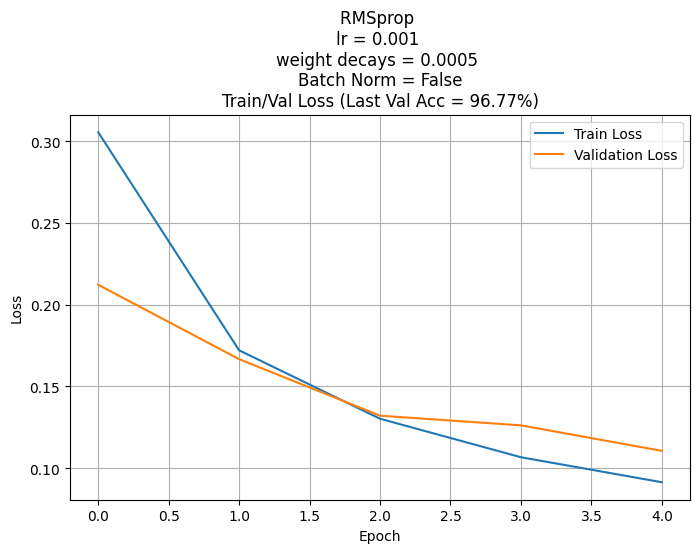


===== TRAINING: RMSprop 
lr = 0.001 
weight decays = 0.001 
Batch Norm = True =====


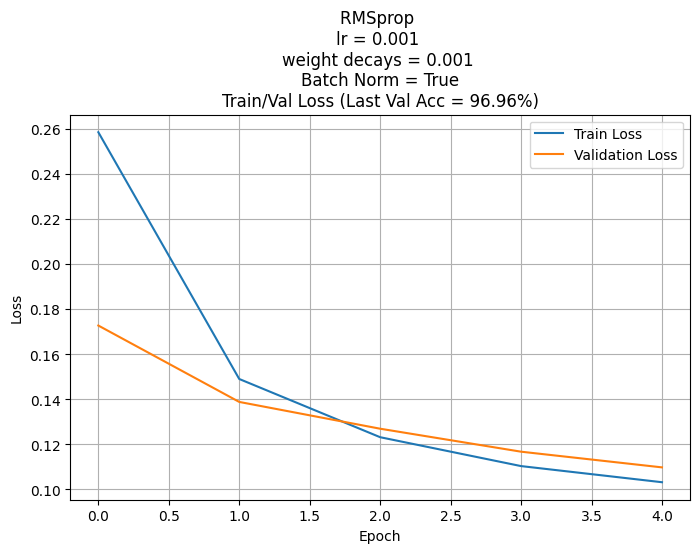


===== TRAINING: RMSprop 
lr = 0.001 
weight decays = 0.001 
Batch Norm = False =====


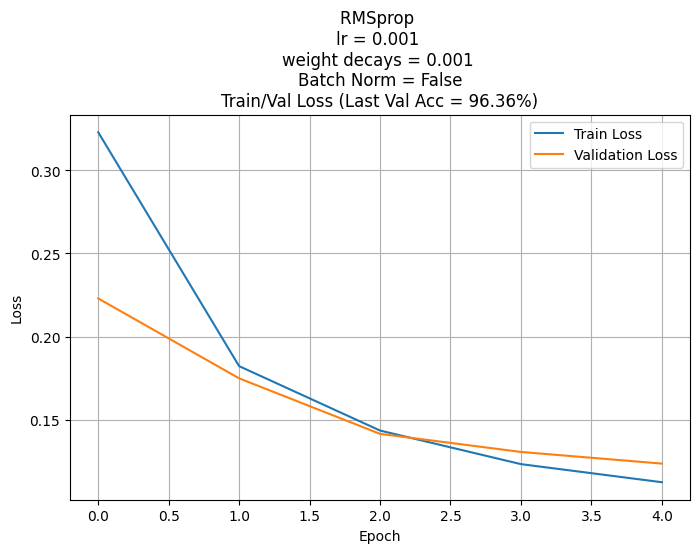


===== TRAINING: RMSprop 
lr = 0.0005 
weight decays = 0.0001 
Batch Norm = True =====


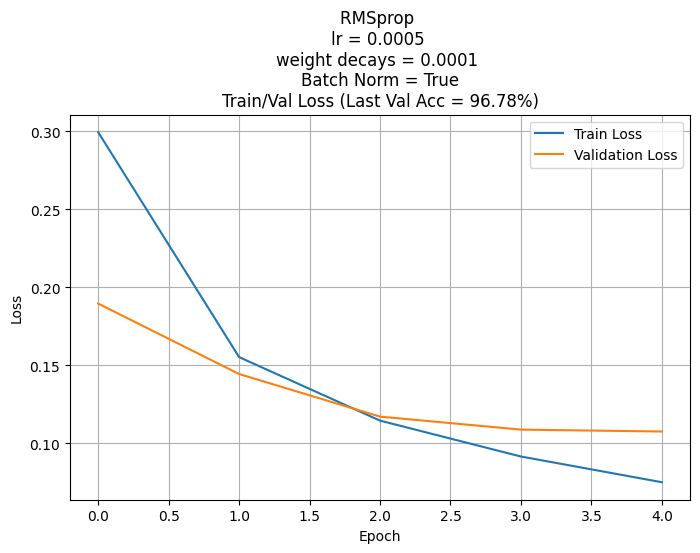


===== TRAINING: RMSprop 
lr = 0.0005 
weight decays = 0.0001 
Batch Norm = False =====


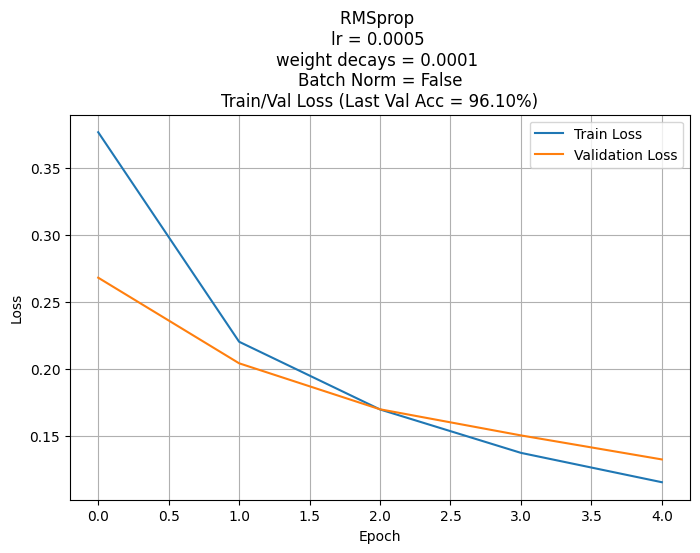


===== TRAINING: RMSprop 
lr = 0.0005 
weight decays = 0.0005 
Batch Norm = True =====


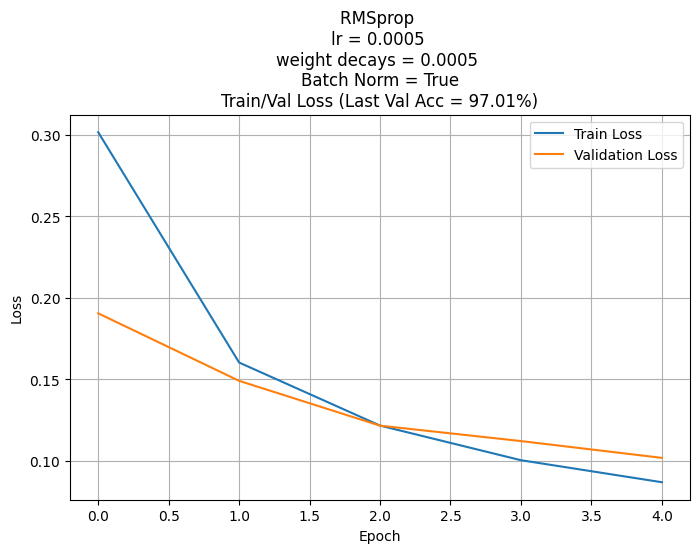


===== TRAINING: RMSprop 
lr = 0.0005 
weight decays = 0.0005 
Batch Norm = False =====


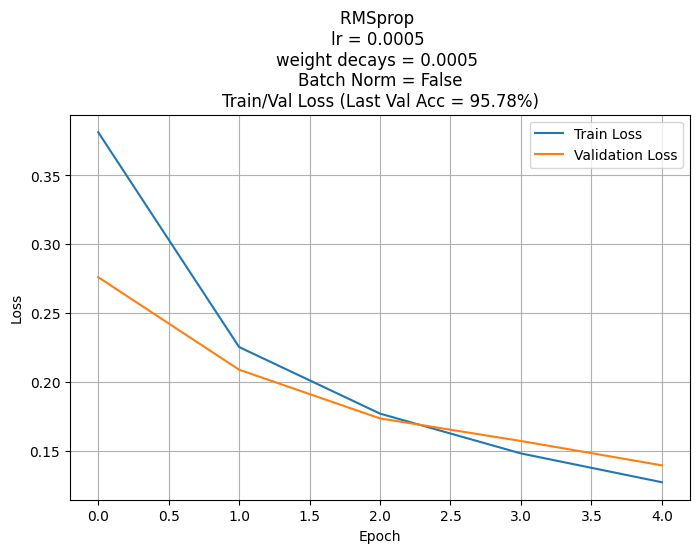


===== TRAINING: RMSprop 
lr = 0.0005 
weight decays = 0.001 
Batch Norm = True =====


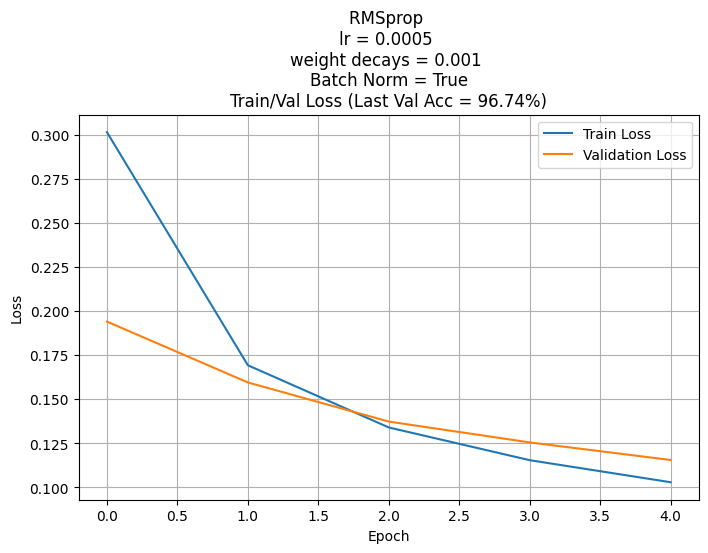


===== TRAINING: RMSprop 
lr = 0.0005 
weight decays = 0.001 
Batch Norm = False =====


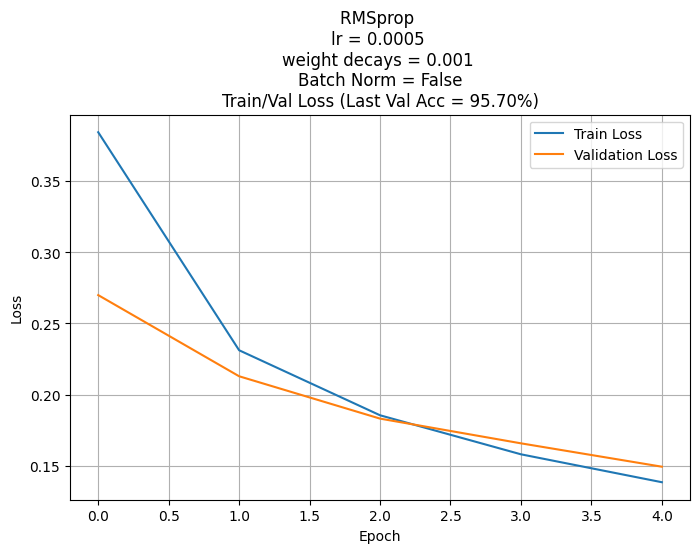


===== TRAINING: RMSprop 
lr = 0.0001 
weight decays = 0.0001 
Batch Norm = True =====


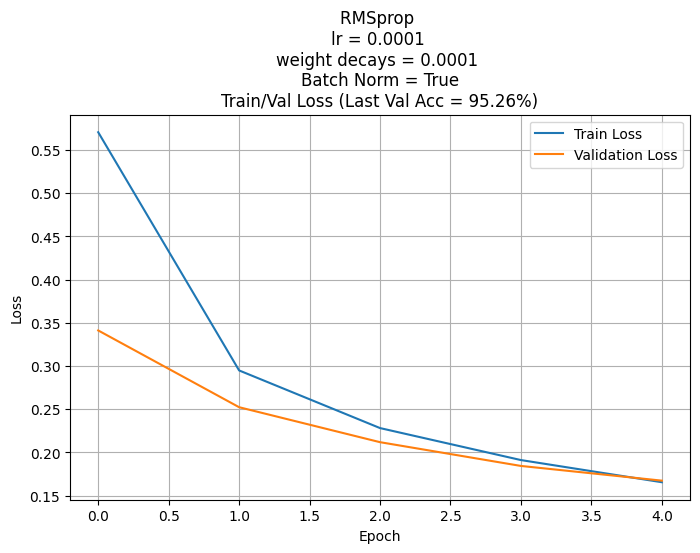


===== TRAINING: RMSprop 
lr = 0.0001 
weight decays = 0.0001 
Batch Norm = False =====


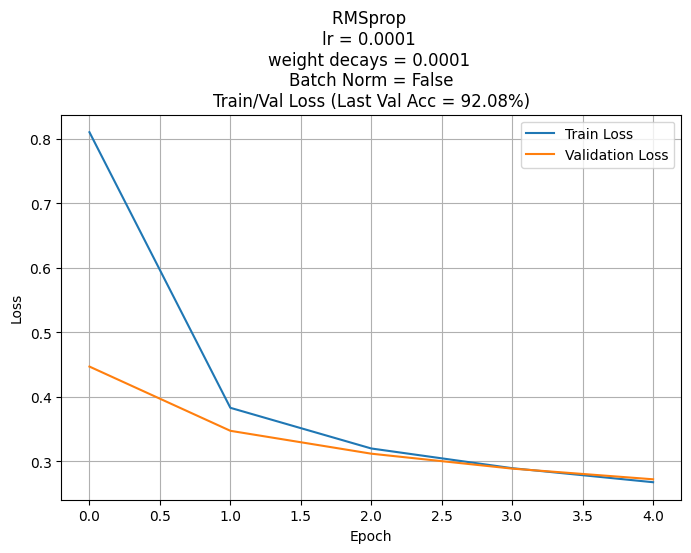


===== TRAINING: RMSprop 
lr = 0.0001 
weight decays = 0.0005 
Batch Norm = True =====


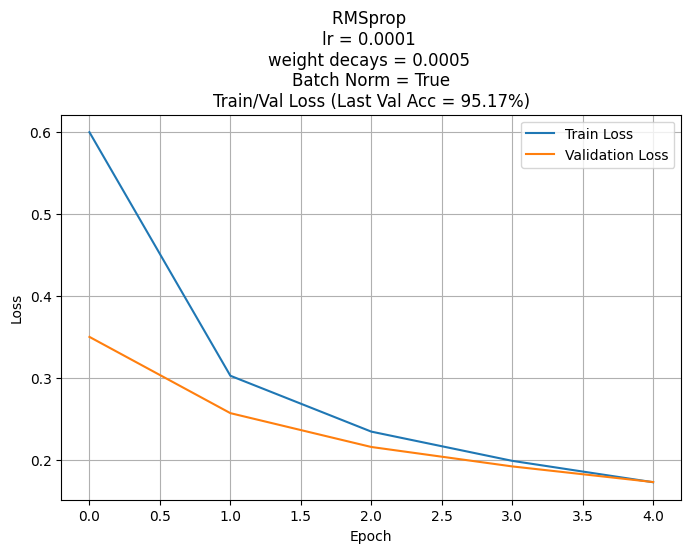


===== TRAINING: RMSprop 
lr = 0.0001 
weight decays = 0.0005 
Batch Norm = False =====


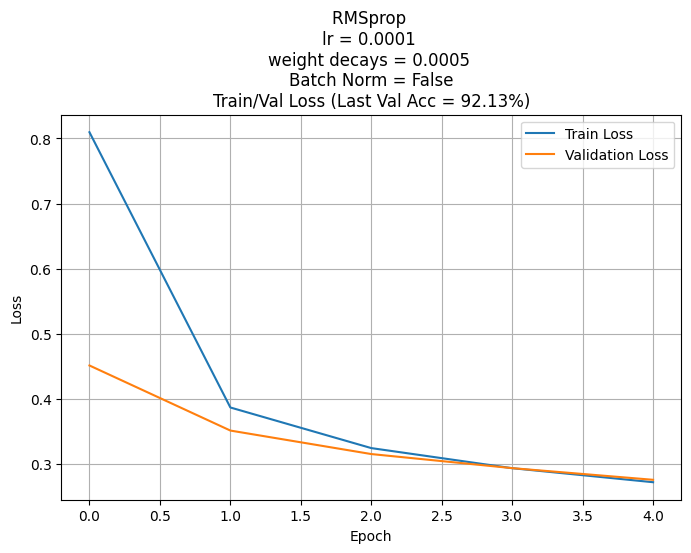


===== TRAINING: RMSprop 
lr = 0.0001 
weight decays = 0.001 
Batch Norm = True =====


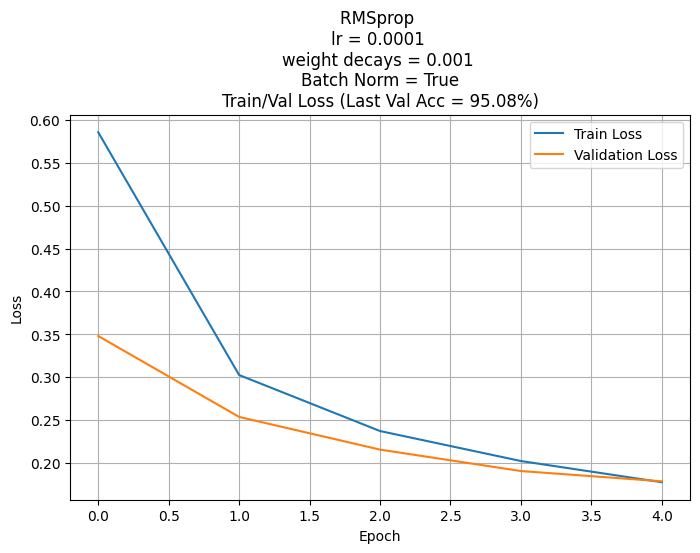


===== TRAINING: RMSprop 
lr = 0.0001 
weight decays = 0.001 
Batch Norm = False =====


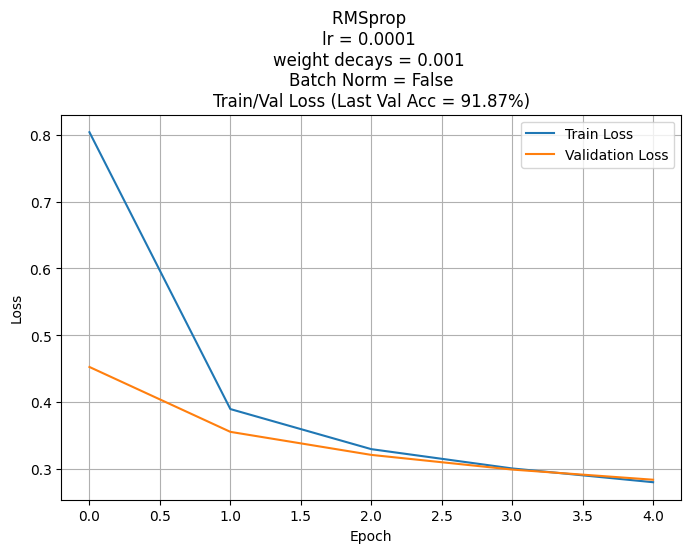

In [28]:
optimizers = ["CustomAdam", "RMSprop"]
lrs = [0.001, 0.0005, 0.0001]
weight_decays = [1e-4, 5e-4, 1e-3]
batch_norm_flags = [True, False]

results = []

for opt_name, lr, wd, bn_flag in itertools.product(optimizers, lrs, weight_decays, batch_norm_flags):
    label = (f"{opt_name} \n"
             f"lr = {lr} \n"
             f"weight decays = {wd} \n"
             f"Batch Norm = {bn_flag}")

    print(f"\n===== TRAINING: {label} =====")
    model = NeuralNetwork(input_dim=28*28, hidden_dim=128, num_classes=10, use_batchnorm=bn_flag)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, wd)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, val_losses, val_acc, test_acc = train_and_validate(
        model,
        train_loader,
        val_loader,
        test_loader,
        loss_fn,
        optimizer,
        num_epochs=5,
        graph_title=label,
        print_test=False
    )

    results.append((label, val_acc, test_acc))

results_sorted = sorted(results, key=lambda x: x[0])


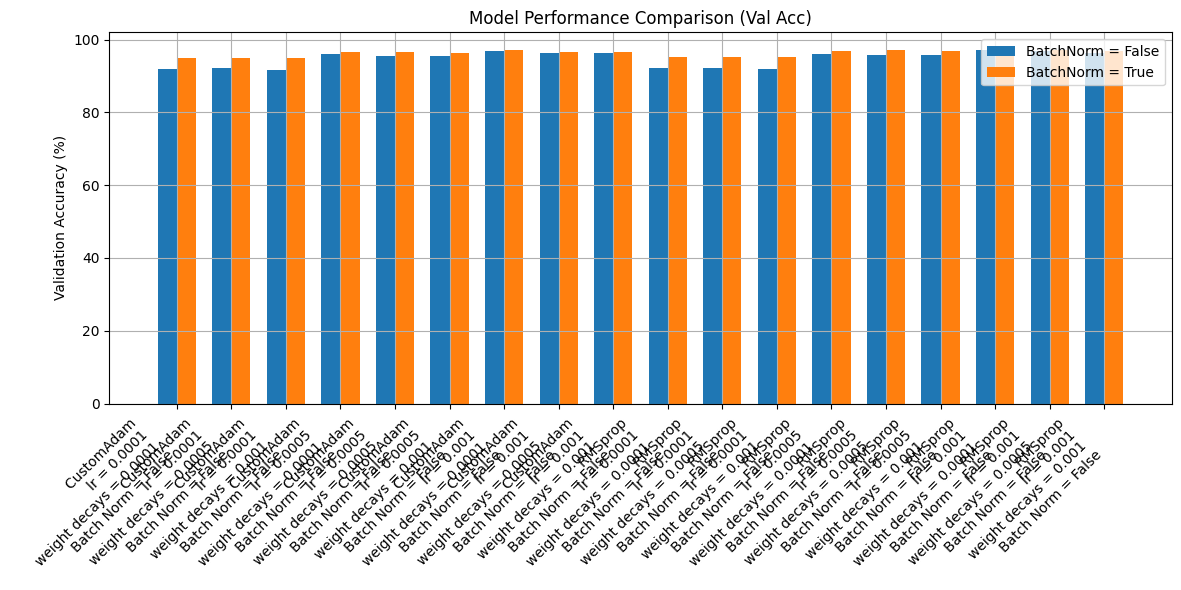

In [29]:
labels = []
val_acc_no_bn = []
val_acc_yes_bn = []

i = 0
while i < len(results_sorted):
    label_false, val_acc_f, test_acc_f = results_sorted[i]
    label_true, val_acc_t, test_acc_t = results_sorted[i+1]

    base_label = label_false.replace("-BNFalse","").replace("-BNTrue","")

    labels.append(base_label)
    val_acc_no_bn.append(val_acc_f)
    val_acc_yes_bn.append(val_acc_t)
    i += 2

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, val_acc_no_bn, width, label='BatchNorm = False')
plt.bar(x + width/2, val_acc_yes_bn, width, label='BatchNorm = True')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Validation Accuracy (%)')
plt.title('Model Performance Comparison (Val Acc)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Исходя из всех графиков, наилучшие результаты получаются для комбинации:
- **Оптимизатор**: CustomAdam
- **Learning rate**: 0.001
- **Weight decay**: 1e-4
- **Batch Normalization**: True